# face2face

Proyecto para las materias de "Aprendizaje (Máquina)" y "Reconocimiento de
patrones" de la FI, UNAM, semestre 2020-1

## Integrantes

- **Aprendizaje (Máquina)**
  - Aguilar Enriquez, Paul Sebastian
  - Cabrera López, Oscar Emilio
- **Reconocimiento de patrones**
  - Aguilar Enriquez, Paul Sebastian
  - Padilla Herrera Carlos Ignacio
  - Ramírez Ancona Simón Eduardo

## Propuesta de proyecto

Implementar una red neuronal basada en la arquitectura pix2pix que sea capaz de
generar rostros con expresiones faciales distintas a las proporcionadas en el
conjunto de datos de entrenamiento, tomando como referencia la posición de otro
rostro.

In [1]:
"""
Importamos paquetes utiles
"""

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython import display
import time

In [2]:
"""
Verificamos la instalación de TensorFlow
"""

print("TensorFlow version: ", tf.__version__)

# Verificamos que podamos utilizar una GPU
print("GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

if tf.test.is_gpu_available():
    print("La GPU esta disponible")
    
if tf.test.gpu_device_name():
    print('GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("Se utilizara el CPU")
    
# Verificamos que podamos utilizar CUDA
if tf.test.is_built_with_cuda():
    print("Se utilizara CUDA")

# Activamos el debug del dispositivo para observar cómo se procesan los datos
#tf.debugging.set_log_device_placement(True)

TensorFlow version:  2.0.0
GPUs disponibles:  1
La GPU esta disponible
GPU: /device:GPU:0
Se utilizara CUDA


In [3]:
"""
Definimos el set de entrenamiento y el de prueba
"""

# Definimos carpetas donde se ubicaran las imagenes
TAGPATHTRAIN = './tagged_train'
INPATHTRAIN = './input_train'
TAGPATHTEST = './tagged_test'
INPATHTEST = './input_test'
OUTPATH = './output'

# Cargamos listado de imagenes
tagurls_train = !ls -1 "{TAGPATHTRAIN}"
inurls_train = !ls -1 "{INPATHTRAIN}"
tagurls_test = !ls -1 "{TAGPATHTEST}"
inurls_test = !ls -1 "{INPATHTEST}"

# Cantidad de imagenes con las que vamos a trabajar
n = 400
# Porcentaje de nuestro set a ser utilizado como entrenamiento
train_percentage = 0.80
# Cantidad de imagenes a utilizar como entrenamiento
train_n = round(n * train_percentage)

# "Revolvemos" el listado para la ejecución de la arquitectura
# así no las tomamos en orden si es que estan clasificadas
#randurls = np.copy(inurls)
np.random.seed(16)
np.random.shuffle(inurls_train)
np.random.shuffle(inurls_test)

# Particionamos los set de datos
tr_urls = inurls_train[:train_n]
ts_urls = inurls_test[:n-train_n]

print("Datos a trabajar: ", n)
print("Set de entrenamiento (total): ", len(inurls_train))
print("Set de entrenamiento (seleccionado): ", len(tr_urls))
print("Set de prueba (total): ", len(inurls_test))
print("Set de prueba (seleccionado): ", len(ts_urls))

Datos a trabajar:  400
Set de entrenamiento (total):  1606
Set de entrenamiento (seleccionado):  320
Set de prueba (total):  251
Set de prueba (seleccionado):  80


In [4]:
"""
Funciones que queremos utilizar en la carga de imagenes
"""
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imagenes
def resize(input_image, target_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    target_image = tf.image.resize(target_image, [height, width],
                                 method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, target_image

# Normaliza el rango de la imagen a [-1, 1]
def normalize(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    
    return input_image, target_image

# Aumentación de datos: Random Crop + Flip
# Basicamente tomamos una misma imágen y le aplicamos otros procesamientos
# para tener más variantes de la misma
@tf.function()
def random_jitter(input_image, target_image):
    
    # Reescalamos la imagen a mayor tamaño
    input_image, target_image = resize(input_image, target_image, 286, 286)
    
    # La empalmamos 
    stacked_image = tf.stack([input_image, target_image], axis=0)
    # Hacemos el recorte aletorio de las dos capas empalmadas 
    # al tamaño de la imagen respetando los 3 canales de colores
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    input_image, target_image = cropped_image[0], cropped_image[1]
    
    # Espejeamos las imagenes
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)
        
    return cropped_image[0], cropped_image[1]

# Cargar imagenes, el augment se utiliza para el set de datos de prueba :)
def load_image(filename, augment, inpath, tagpath):
    # Cargamos la imagen en formato jpeg en valores decimales y solo las componentes RGB
    input_image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(inpath + '/' + filename)), tf.float32)[..., :3]
    target_image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(tagpath + '/' + filename)), tf.float32)[..., :3]
    
    input_image, target_image = resize(input_image, target_image, IMG_HEIGHT, IMG_WIDTH)
    
    if augment:
        input_image, target_image = random_jitter(input_image, target_image)
        
    input_image, target_image = normalize(input_image, target_image)
    
    # Hay que sumarle 1 y dividir entre 2 porque tenemos
    # nuetro rango de imagenes de [-1, 1]
    return input_image, target_image

# Cargar imagenes para entrenamiento con "más datos"
def load_train_image(filename):
    return load_image(filename, True, INPATHTRAIN, TAGPATHTRAIN)

# Cargar imagenes para prueba sin "más datos"
def load_test_image(filename):
    return load_image(filename, False, INPATHTEST, TAGPATHTEST)

In [5]:
"""
Cargamos datos
"""
BATCH_SIZE = 1

# Creamos set de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
# Cargamos las imagenes de entrenamiento
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Recuerda, en el paper se utiliza un batch de 1
train_dataset = train_dataset.batch(BATCH_SIZE)

# Creamos set de prueba
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
# Cargamos las imagenes de prueba
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Recuerda, en el paper se utiliza un batch de 1
test_dataset = test_dataset.batch(BATCH_SIZE)

In [6]:
"""
Creamos los bloques para el generador y el discriminador
"""

# Esto nos permite crear las capas del encoder
def downsample(filters, apply_batchnorm = True):
    
    # Ruido aleatorio Gaussiano
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Indicamos que sera una secuencia de capas
    result = tf.keras.Sequential()
    
    # Capa convolucional
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            kernel_size = 4,
            strides = 2,
            padding = 'same',
            kernel_initializer = initializer,
            use_bias = not apply_batchnorm))
    
    # Hay capas que no llevan BatchNorm
    if apply_batchnorm:
        # Capa de BatchNorm
        result.add(tf.keras.layers.BatchNormalization())
        
    # Capa de activación
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

# Esto nos permite crear las capas del decoder
def upsample(filters, apply_dropout = False):
    
    # Ruido aleatorio Gaussiano
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Indicamos que sera una secuencia de capas
    result = tf.keras.Sequential()
    
    # Capa convolucional
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            kernel_size = 4,
            strides = 2,
            padding = 'same',
            kernel_initializer = initializer,
            use_bias = False))
    
    # Capa de BatchNorm
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        # Capa de Dropout
        result.add(tf.keras.layers.Dropout(0.5))
        
    # Capa de activación
    result.add(tf.keras.layers.ReLU())
    
    return result

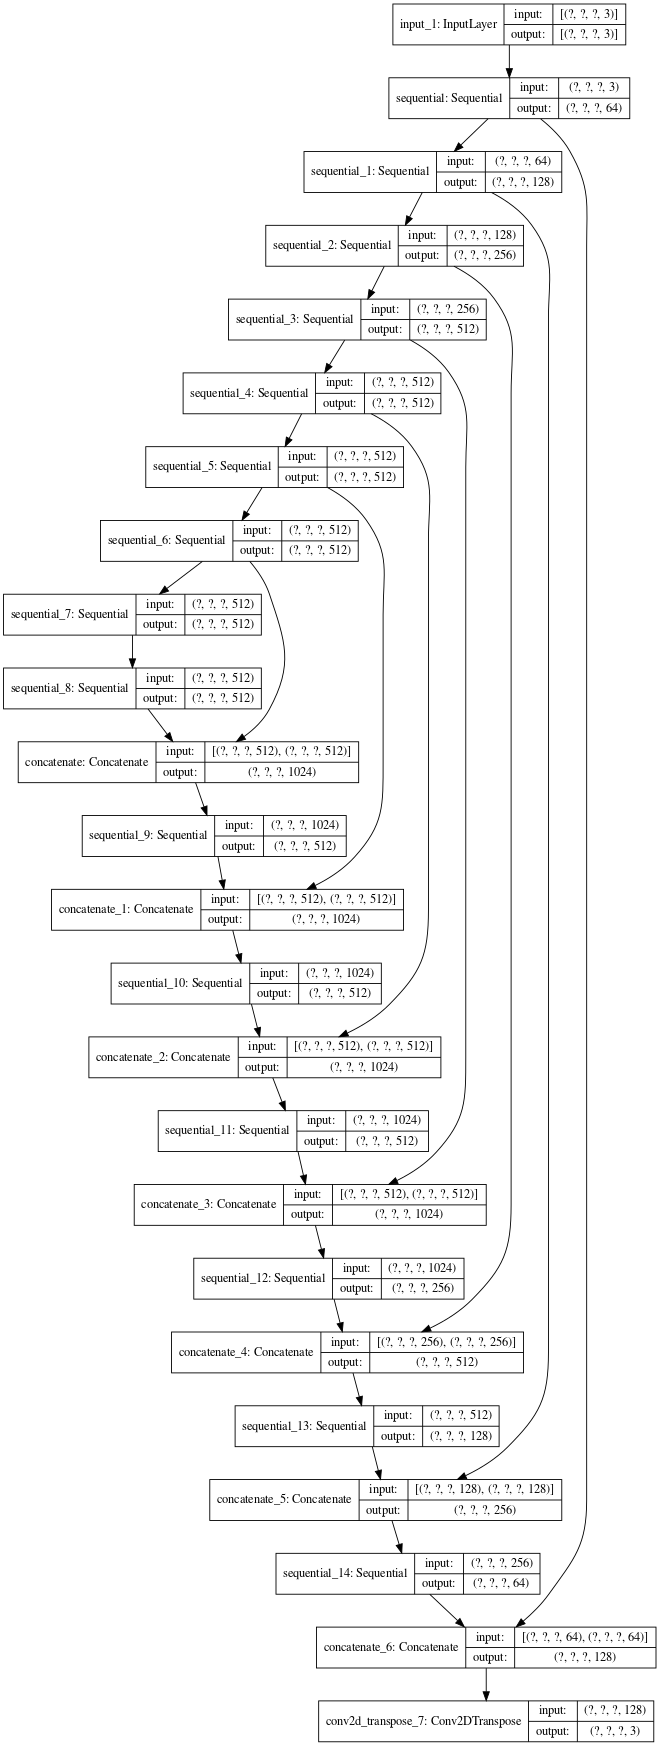

In [7]:
"""
Creamos el generador, es una arquitectura tipo U-Net con skip_connections
"""

def Generator():
    # No especificamos el tamño de la imagen pero si los canales de colores
    # Dejamos abierto a que la imagen de entrada pueda tener cualquier tamaño
    inputs = tf.keras.layers.Input(shape = [None,None,3])
    
    # Lista de bloques de downsamples a aplicar
    down_stack = [
        downsample(64, apply_batchnorm = False), # (bs, 128, 128, 64)
        downsample(128),                       # (bs, 64, 64, 128)
        downsample(256),                       # (bs, 32, 32, 256)
        downsample(512),                       # (bs, 16, 16, 512)
        downsample(512),                       # (bs, 8, 8, 512)
        downsample(512),                       # (bs, 4, 4, 512)
        downsample(512),                       # (bs, 2, 2, 512)
        downsample(512)                       # (bs, 1, 1, 512)
    ]
    
    # Lista de bloques de upsamples a aplicar
    up_stack = [
        upsample(512, apply_dropout = True), # (bs, 2, 2, 1024)
        upsample(512, apply_dropout = True), # (bs, 4, 4, 1024)
        upsample(512, apply_dropout = True), # (bs, 8, 8, 1024)
        upsample(512),                     # (bs, 16, 16, 1024)
        upsample(256),                     # (bs, 32, 32, 512)
        upsample(128),                     # (bs, 64, 64, 256)
        upsample(64)                      # (bs, 128, 128, 128)
    ]

    
    # Ruido aleatorio Gaussiano
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Ultima capa!
    last = tf.keras.layers.Conv2DTranspose(
                filters = 3,
                kernel_size = 4,
                strides = 2,
                padding = 'same',
                kernel_initializer = initializer,
                activation ='tanh') # (bs, 256, 256, 3)
    
    # Asignamos la entrada configurada a X
    x = inputs
    
    # El generador es una arquitectura tipo U-NET, por lo cual lleva 
    # skip_conecctions
    skips = []
    
    # Conectamos las capas de reducción y las skip_connections
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    # Invertimos las conexones y evitamos el cuello de botella
    skips = reversed(skips[:-1])
    
    # Conectamos las capas de aumento y las skip_conecctions
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

# Creamos el generador
generator = Generator()
# Veamos nuestro hermoso generador
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

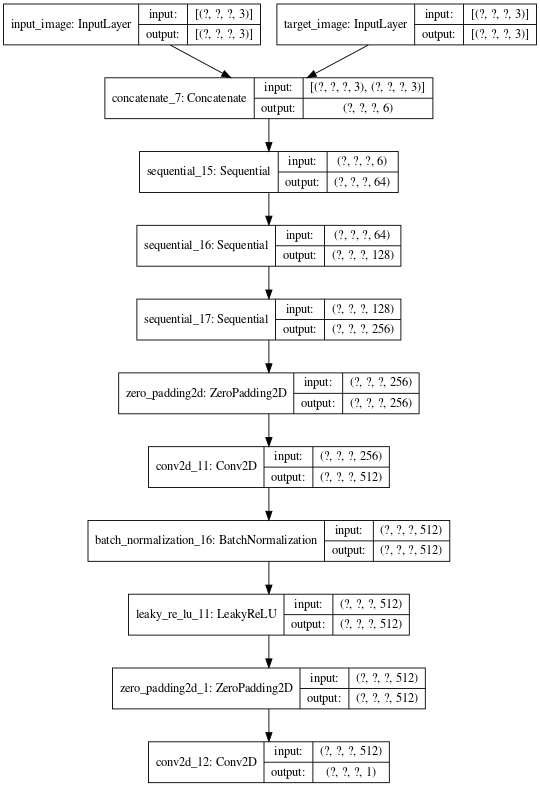

In [8]:
"""
Creamos el discriminador, es una arquitectura tipo PatchGAN
"""

def Discriminator():
    
    # Requerimos acceso al input del generador para comparar con la de entrada
    # Igual dejamos los tamaños abiertos
    inp = tf.keras.layers.Input(shape=[None, None, 3], name = 'input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name = 'target_image')
    
    # Concatenamos las dos imagenes como entrada
    x = tf.keras.layers.concatenate([inp, tar])        # (bs, 256, 256, channels*2)

    # Ruido aleatorio Gaussiano
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Seguimos la arquitectura propuesta del discriminador para 
    # la PatchGAN
    
    # Downsample
    down1 = downsample(64, apply_batchnorm = False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128)(down1)                     # (bs, 64, 64, 128)
    down3 = downsample(256)(down2)                     # (bs, 32, 32, 256)
    #down4 = downsample(512)(down3)                     # (bs, 16, 16, 512)
    
    # Padding
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    
    # Convolution
    conv = tf.keras.layers.Conv2D(
                filters = 512,
                kernel_size = 4,
                strides = 1,
                kernel_initializer = initializer,
                use_bias=False)(zero_pad1)             # (bs, 31, 31, 512)
    
    # BatchNorm
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    
    # LeakyReLU
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    # Padding
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    
    # Convolucion
    last = tf.keras.layers.Conv2D(
                filters = 1,
                kernel_size = 4,
                strides = 1,
                kernel_initializer = initializer,
                padding = "same")(zero_pad2) # (bs, 30, 30, 1)
                #padding = "same")(down4) # (bs, 30, 30, 1)
  
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Creamos el discriminador
discriminator = Discriminator()
# Veamos nuestro hermoso discriminador
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [9]:
"""
Funciones de costo/perdida del generador y el discriminador
"""

# Calcular la entropia cruzada de cada imagen poara evaluar el resultado
# de las imagenes que vayamos obteniendo
# Se va a pasar por una función sigmode para normalizarlas
# al dominio de 0 a 1 (from_logits=True)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Definido en el paper
# LAMBDA permite añadir mas error en el generador
# Si se hace mas pequeña se aumenta el error en el adversario
LAMBDA = 100

# Función de costo del generador
def generator_loss(disc_generated_output, gen_output, target):
    # Diferencia entre la imagen generada y lo que se esperaba generar
    # Nos dice si estamos engañando al discrminador, es la parte adversaria
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # Diferencia por pixeles en valor absoluto entre la imagen real y la generada
    # mean absolute error entre las imagenes
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    # Este valor define a nuestro generador
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss


# Función de costo del discriminador
def discriminator_loss(disc_real_output, disc_generated_output):
    # Diferencia entre los true por ser real y el detectado por el discriminador
    # Nos dice que tanto de los pixeles son reales
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    # Diferencia entre los false por ser generado y el detectado por el discriminador
    # Nos dice que tanto de los pixeles son falsos
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    # Este valor define a nuestro discrminador
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [10]:
"""
Funciones utiles
"""
# Optimizadores de nuestras funciones, se utiliza Adam como base
# Tambien especificado en el paper
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoints, esto para guardar los estados del generador y el discriminador
# por si interrumpimos la ejecucicón no perder el trabajo realizado
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
                generator_optimizer = generator_optimizer,
                discriminator_optimizer = discriminator_optimizer,
                generator = generator,
                discriminator = discriminator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Nos permite evaluar el comportamiento del generador durante el entrenamiento
# Podemos guardar las imagenes en un directorio para hacer alguna animacion
def generate_images(model, test_input, tar, save_filename = False, display_imgs = False):
    prediction = model(test_input, training=True)
    
    if save_filename:
        if not os.path.exists(OUTPATH):
            os.mkdir(OUTPATH)
        tf.keras.preprocessing.image.save_img(OUTPATH + '/' + save_filename + '.jpg', prediction[0,...])
    
    if display_imgs:
        plt.figure(figsize = (15,15))
        display_list = [test_input[0], tar[0], prediction[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

In [11]:
"""
Función de entrenamiento
"""

# Definimos como sera la interacción entre generador y discriminador
# Basicamente el entrenamiento por cada paso
@tf.function()
def train_step(input_image, target, epoch):
    # Autodiferenciación, basicamente backpropagation :D las ecuaciones diferenciales
    # Los gradientes pues' , tomando en cuenta la soptimizaciones con Adam
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))

def train(epochs):
    start1 = time.time()
    for epoch in range(epochs):
        start = time.time()
        
        imgi = 0
        for input_image, target_image in train_dataset:
            print("Epoch: ", epoch, "\tTrain: ", imgi, "/", len(tr_urls))
            train_step(input_image, target_image, epoch)
            imgi += 1
            display.clear_output(wait=True)
        
        imgi = 0
        to_save = 3
        for input_image_t1, target_image_t1 in test_dataset.take(to_save):
            print("Epoch: ", epoch, "\tTest: ", imgi, "/", len(ts_urls))
            generate_images(generator, input_image_t1, target_image_t1, str(imgi) + '_' + str(epoch), display_imgs = False)
            imgi += 1
            display.clear_output(wait=True)
            
        for input_image_t2, target_image_t2 in test_dataset.skip(to_save):
            print("Epoch: ", epoch, "\tTest: ", imgi, "/", len(ts_urls))
            generate_images(generator, input_image_t2, target_image_t2, save_filename = False, display_imgs = False)
            imgi += 1
            display.clear_output(wait=True)

        # guardando (checkpoint) el modelo cada 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
    checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time taken for train is {} sec\n'.format(time.time()-start1))

In [12]:
# Con entrenamiento despues de la primera ejecución
train(50)

Time taken for train is 3064.559027671814 sec



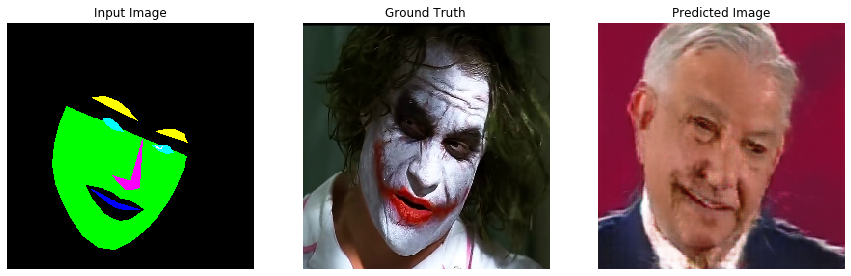

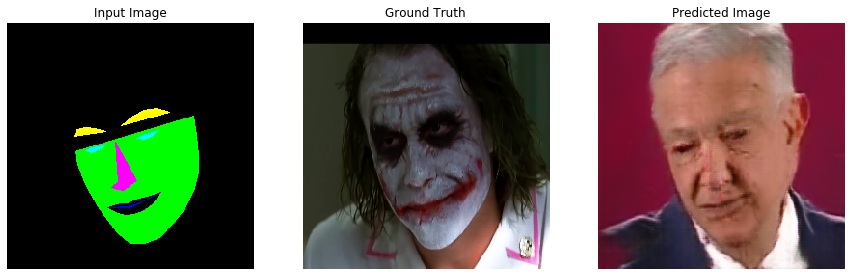

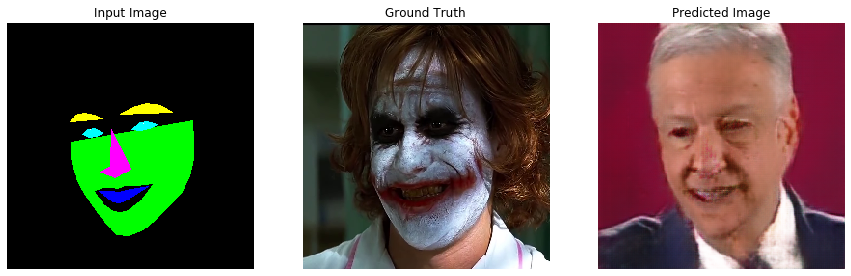

In [13]:
# Sin entrenamiento como tal, solo generamos las imagenes
for example_input, example_target in test_dataset.take(3):
    generate_images(generator, example_input, example_target, save_filename = False, display_imgs = True)